# Tests

## Test architectures

In [9]:
import importlib

from custom_architectures import sota_eeg_arch

importlib.reload(sota_eeg_arch)

model = sota_eeg_arch.EEGSimpleConv(
    input_shape = (None, 22), output_dim = 4, multi_subjects = True
)
print(model.count_params())
print(len(model.layers))
model.summary()

4 109 8
2465604
35
Model: "EEGSimpleConv"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_eeg (InputLayer)      [(None, None, 22)]        0         
                                                                 
 conv1d_57 (Conv1D)          (None, None, 109)         19184     
                                                                 
 batch_normalization_57 (Ba  (None, None, 109)         436       
 tchNormalization)                                               
                                                                 
 activation_64 (Activation)  (None, None, 109)         0         
                                                                 
 conv1d_58 (Conv1D)          (None, None, 109)         95048     
                                                                 
 batch_normalization_58 (Ba  (None, None, 109)         436       
 tchNormalization)                

In [18]:
print(model.input_shape, model.output_shape)

(None, None, 22) (None, 32)


## Step-by-step scenario execution

In [1]:
import json
import shutil
import logging
import importlib
import numpy as np
import pandas as pd
import tensorflow as tf

from utils import *
from models import *
from custom_train_objects.generators import EEGGrouperGenerator
from experiments import data_utils, model_utils, scenarios_utils, scenarios

logger = logging.getLogger(__name__)

set_display_options()

for module in (model_utils, data_utils, scenarios_utils, scenarios): importlib.reload(module)

name = 'atcnet_ge2e_nlab-4_nut-64_metric-cosine_dim-16_norm-no_win-10_subj-{subject}_run-10_scenario-4'
name = 'atcnet_ge2e_loso-s1_nlab-4_nut-64_metric-cosine_dim-16_norm-no_win-10_subj-{subject}_run-10_scenario-5'
name = 'eegsimpleconv_ea_rate-95_winoff-499_winlen-1001_bs-16_subj-1_run-10_scenario-3'
name = 'eegsimpleconv_ea_rate-70_winoff-499_winlen-1001_bs-288_norm-no_loso-s1_subj-{subject}_run-10_scenario-5'
name = 'eegsimpleconv_ge2e_nlab-4_nut-64_dim-16_ea_rate-70_winoff-499_winlen-1001_norm-no_win-10_loso-s1_subj-{subject}_run-10_scenario-5'
#name = 'eegsimpleconv_ge2e_loso-s1_nlab-4_nut-64_metric-cosine_dim-16_norm-no_win-10_subj-{subject}_run-10_scenario-5'
name = 'atcnet_ge2e_ea_loso-s1_nlab-4_nut-64_metric-cosine_dim-16_norm-no_win-10_subj-{subject}_run-10_scenario-5'

name = 'atcnet_norm-no_subj-1_run-10_scenario-3'
name = 'atcnet_ea_norm-no_subj-1_run-10_scenario-3'
name = 'atcnet_ea_norm-no_subj-{subject}_run-10_scenario-4'

name = 'eegsimpleconv_ge2e_nlab-4_nut-24_dim-64_rate-70_winoff-499_winlen-1001_ea_norm-no_loso-s1_subj-1-2-3-4-5-6-7-8-9_run-10_scenario-5'
#name = 'eegsimpleconv_rate-70_winoff-499_winlen-1001_bs-288_ea_norm-no_loso-s1_subj-1-2-3-4-5-6-7-8-9_run-10_scenario-5'
#name = 'atcnet_ge2e_nlab-4_nut-64_dim-64_ea_norm-no_loso-s1_subj-1-2-3-4-5-6-7-8-9_run-10_scenario-5'
#name = 'atcnet_ea_norm-no_loso-s1_subj-1-2-3-4-5-6-7-8-9_run-10_scenario-5'

#name = 'eegsimpleconv_ge2e_nlab-4_nut-256_task-pi_ttask-pi_rate-95_winlen-1001_winoff-499_win-5_split_norm-no_subj-5-6-7-8-9_run-10_scenario-2'

name = 'singlechannelcombination_ge2e_nlab-4_nut-24_dim-64_rate-95_winoff-499_winlen-1001_ea_norm-no_subj-1_run-10_scenario-3'

name = 'eegsimpleconv_ge2e_nlab-4_nut-24_dim-64_rate-95_winoff-499_winlen-1001_ea_mixup_norm-no_subj-1_run-10_scenario-3'
name = 'eegsimpleconv_ge2e_nlab-4_nut-24_dim-64_rate-70_winoff-499_winlen-1001_ea_norm-no_mixup_loso-s1_subj-{subject}_run-10_scenario-5'

name = 'atcnet_norm-sess_nostrat_nostop_subj-6_run-42_scenario-3'
name = 'atcnetv2_fit_ge2e_nlab-4_nut-24_dim-64_ea_norm-no_subj-6_run-42_scenario-3'

name = 'atcnetv2_fit_norm-no_subj-1_run-42_scenario-3'

name = 'atcnetv2_fit_ge2e_metric-cosine_nlab-4_nut-16_dim-64_norm-no_loso-s6_subject-1-2-3-4-5-6-7-8-9_run-10_scenario-5'

name = 'eegsimpleconv_fit_rate-70_winoff-499_winlen-1001_bs-288_norm-gno_loso-s7_subj-{subject}_run-10_scenario-5'
name = 'eegsimpleconv_fit_rate-95_winoff-499_winlen-1001_bs-16_ea_norm-gno_subj-2_run-10_scenario-3'

name = 'eegnet_fit_norm-gno_subj-2_run-42_scenario-3'

name = 'atcnetv2_fit_ge2e_metric-euclidian_nlab-4_nut-24_dim-64_ea_norm-no_subj-1_run-42_scenario-3'

name = scenarios_utils.format_model_name(name, subject = range(1, 10))
assert isinstance(name, str) or len(name) == 1, str(name)
if not isinstance(name, str): name = name[0]

tf.config.set_visible_devices([], 'GPU')

load      = True
overwrite = False
overwrite_eval = False
if overwrite:
    for path in ('pretrained_models', 'evaluations'):
        try:
            shutil.rmtree(path + '/' + name)
        except:
            pass

config = scenarios._get_scenario_config(name, skip_new = True)
scenarios_utils.validate_scenario_config(config)

name = config['model_name']
config['metrics'] = scenarios._get_metrics(name, config = config)

if load or all(metric is None for name, metric in config['metrics'].items()):
    if config['skip_new'] and not is_model_name(name):
        logger.info('New model {} skipped'.format(config['model_name']))
    else:
        scenarios._setup_gpu_config(config)
        
        random_state = None if not isinstance(config['run'], int) else config['run']
        if random_state is not None:
            np.random.seed(random_state)
            tf.random.set_seed(random_state)
    
        train, valid, test, config = data_utils.get_experimental_data(
            config, random_state = random_state
        )
        scenarios_utils.validate_scenario_data(config, train = train, valid = valid, test = test)

        model, config = model_utils.build_model(name, config)

        filepath =  '{}/best_weights.keras'.format(model.save_dir)
        if model.epochs == 0 and not os.path.exists(filepath) and not config['skip_new']:
            config['train_config']['test_size'] = 0
            if 'fit' in model.nom:
                scenarios.fit_model(model, config, train = train, valid = valid, filepath = filepath)
            else:
                scenarios.train_model(model, config, train = train, valid = valid, filepath = filepath, verbose = 2)

        metrics = scenarios.evaluate_model(
            model = model, data = test, config = config, filepath = filepath, samples = train, overwrite = overwrite_eval
        )
    
        config['metrics'] = scenarios._get_metrics(name, config = config, metrics = metrics)

print(json.dumps(to_json(config), indent = 4))

2024-04-11 15:05:08.090851: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-11 15:05:08.121959: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 15:05:08.121986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 15:05:08.122749: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-11 15:05:08.127691: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
experimental_follow_type_hints is deprecated
Loading dataset bciiv2a...

Dataset information

General :
  - sampling rate  : 250
  - # EEG channels : 22
  - Labels (n = 4) : {'left hand (IM)', 'feet (IM)', 'right hand (IM)', 'tongue (IM)'}

# Samples :
  - Train size    : 230
  - Valid size    : 58
  - Test size     : 288
  - valid == test : False

Subjects :
  - # subject(s) in train : 1
  - # subject(s) in valid : 1
  - # subject(s) in test  : 1
  - # subject(s) in train and valid : 1
  - # subject(s) in train and test  : 1

Sessions :
  - # session(s) in train : 1
  - # session(s) in valid : 1
  - # session(s) in test  : 1
  - # session(s) in train and valid : 1
  - # session(s) in train and test  : 0

Model restoration...
Model model has not been restored due to an exception : Requested the deserialization of a Lambda layer with a Python `lambda` inside it. This carries a potential risk of arbitrary code execution and thus it is disallowed by default. If 

In [ ]:
config

In [ ]:
model.plot_history()
print(model.history)

In [ ]:
from utils import *

show_memory()

### Evaluation of LOSO with Euclidian Alignment using the alignment of different subjects

Using EA improves performances in LOSO of up to 15%, but it is not a *correct online* procedure as it requires *à priori* data to compute the alignment matrix for the subject. This test aims to demonstrate that using the alignment of other subjects may still be relevant as a basis.

The next objective is to automatically find the *nearest subject*, i.e., the one with the most relevant matrix, as this test demonstrates that performances go from 50 to 75% depending on the matrix used.

In [67]:
samples = train
if config['dataset_config']['loso']:
    mask = test['session'] == sorted(test['session'].unique())[-1]
    test, samples = test[mask], pd.concat([samples, test[~mask]])
    samples = train

if hasattr(model, 'build_samples'):
    samples = model.build_samples(samples)
    print('Samples shape : {}'.format(tf.nest.map_structure(lambda t: tuple(t.shape), samples)))

new_test = test.copy()
for subj_id in train['id'].unique():
    new_test['id'] = subj_id
    metrics = scenarios.evaluate_model(
        model = model, data = new_test, test_name = 'test', config = config, filepath = filepath, samples = samples, save = False, overwrite = True
    )

metrics = scenarios.evaluate_model(
    model = model, data = test, test_name = 'test', config = config, filepath = filepath, samples = samples, save = False, overwrite = True
)

config['metrics'] = scenarios._get_metrics(name, config = config, metrics = metrics)
print(json.dumps(config, indent = 4))

Timers for logger timer :
- predict : 2.005 sec
  - pre-processing executed 5 times : 1.858 sec (371 ms / exec)
  - inference executed 5 times : 88 ms (17 ms / exec)
    - _compute_metrics executed 5 times : 3 ms (615 μs / exec)
Model `eegsimpleconv_rate-70_winoff-499_winlen-1001_bs-288_ea_norm-no_loso-s1_subj-1-2-3-4-5-6-7-8-9_run-10_scenario-5` metrics : {
    "test_accuracy": 0.8090277777777778
}
Timers for logger timer :
- predict : 1.912 sec
  - pre-processing executed 5 times : 1.846 sec (369 ms / exec)
  - inference executed 5 times : 7 ms (1 ms / exec)
    - _compute_metrics executed 5 times : 3 ms (648 μs / exec)
Model `eegsimpleconv_rate-70_winoff-499_winlen-1001_bs-288_ea_norm-no_loso-s1_subj-1-2-3-4-5-6-7-8-9_run-10_scenario-5` metrics : {
    "test_accuracy": 0.5138888888888888
}
Timers for logger timer :
- predict : 1.915 sec
  - pre-processing executed 5 times : 1.849 sec (369 ms / exec)
  - inference executed 5 times : 7 ms (1 ms / exec)
    - _compute_metrics executed 

### Person Identification for automatic EA-substitute detection

In [69]:
from utils.eeg_utils import *

subj_encoder_name = 'eegsimpleconv_ge2e_nlab-4_nut-256_task-pi_ttask-pi_rate-95_winlen-1001_winoff-499_win-5_split_norm-no_subj-5-6-7-8-9_run-10_scenario-2'
subj_encoder      = get_pretrained(subj_encoder_name)

samples = train
if config['dataset_config']['loso']:
    mask = test['session'] == sorted(test['session'].unique())[-1]
    test, samples = test[mask], pd.concat([samples, test[~mask]])
    samples = train

if hasattr(subj_encoder, 'build_samples'):
    subj_samples = subj_encoder.build_samples(split_channels(samples))
    subj_samples['labels'] = subj_samples['ids']
    print('Samples shape : {}'.format(tf.nest.map_structure(lambda t: tuple(t.shape), subj_samples)))

Samples shape : {'ids': (81092,), 'channels': (81092,), 'embeddings': (81092, 32), 'labels': (81092,)}


In [70]:
subj_samples['labels'] = tf.as_string(subj_samples['labels'])

In [85]:
new_test = test.copy()
new_ids  = []
for idx, row in new_test.iterrows():
    results = {}
    for i in range(row['n_channels']):
        labels, scores = subj_encoder.infer(subj_encoder.get_input(
            {'eeg' : row['eeg'][i : i + 1], 'rate' : row['rate'], 'channels' : row['channels'][i : i + 1]}
        )[tf.newaxis], samples = subj_samples, k = 11, weighted = False)
        for lab, s in zip(convert_to_str(labels), scores[0].numpy()):
            results.setdefault(lab, []).append(s)
    results = {k : np.sum(v) for k, v in results.items()}
    new_ids.append(sorted(results.keys(), key = results.get)[-1])

new_test['id'] = new_ids

In [87]:
if hasattr(model, 'build_samples'):
    samples = model.build_samples(train)
    print('Samples shape : {}'.format(tf.nest.map_structure(lambda t: tuple(t.shape), samples)))

metrics = scenarios.evaluate_model(
    model = model, data = new_test, test_name = 'test', config = config, filepath = filepath, samples = samples, save = False, overwrite = True
)

config['metrics'] = scenarios._get_metrics(name, config = config, metrics = metrics)
print(json.dumps(config, indent = 4))

Samples shape : {'ids': (3686,), 'channels': (3686, 22), 'embeddings': (3686, 64), 'labels': (3686,)}
Timers for logger timer :
- predict : 3.805 sec
  - pre-processing executed 9 times : 3.676 sec (408 ms / exec)
  - inference executed 9 times : 124 ms (13 ms / exec)
    - _compute_metrics executed 9 times : 95 ms (10 ms / exec)
Model `eegsimpleconv_ge2e_nlab-4_nut-24_dim-64_rate-70_winoff-499_winlen-1001_ea_norm-no_loso-s1_subj-1-2-3-4-5-6-7-8-9_run-10_scenario-5` metrics : {
    "test_accuracy": 0.5868055555555556,
    "test_subj-BCI-IV 2a-2_sess-BCI-IV 2a-1-session 1_accuracy": 0.6071428571428571,
    "test_subj-BCI-IV 2a-2_sess-BCI-IV 2a-1-session 2_accuracy": 0.6571428571428571,
    "test_subj-BCI-IV 2a-3_sess-BCI-IV 2a-1-session 1_accuracy": 0.6666666666666666,
    "test_subj-BCI-IV 2a-3_sess-BCI-IV 2a-1-session 2_accuracy": 0.625,
    "test_subj-BCI-IV 2a-4_sess-BCI-IV 2a-1-session 1_accuracy": 0.6666666666666666,
    "test_subj-BCI-IV 2a-4_sess-BCI-IV 2a-1-session 2_accuracy":

In [78]:
new_test['id'].value_counts()

BCI-IV 2a-2    83
BCI-IV 2a-4    49
BCI-IV 2a-3    43
BCI-IV 2a-5    39
BCI-IV 2a-8    31
BCI-IV 2a-6    22
BCI-IV 2a-7    17
BCI-IV 2a-9     4
Name: id, dtype: int64

### Prediction analysis for embedding-based models

In [3]:
outputs = tf.keras.layers.Concatenate()([
    model.model.get_layer('lambda_{}'.format(i + 1)).output for i in range(5)
])
encoder = tf.keras.Model(model.model.inputs, outputs)
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_eeg (InputLayer)      [(None, 1125, 22, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 1125, 22, 16)         1024      ['input_eeg[0][0]']           
                                                                                                  
 batch_normalization (Batch  (None, 1125, 22, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 depthwise_conv2d (Depthwis  (None, 1125, 1, 32)          704       ['batch_normalization[0][0

In [2]:
from utils.eeg_utils import *
model.load_weights(filepath)

try:
    encoder
except:
    encoder = model

train_samples = pd.concat([train, valid])
train_samples = train
#train_samples = train_samples[train_samples['artifact'] == 0]
if 'window_index' in train.columns: train_samples = train_samples[train_samples['window_index'] == 0]
#if len(train['id'].unique()) > 1 and not config['dataset_config']['loso']:
#    train_samples = train_samples[train_samples['id'].apply(lambda id: id.endswith('-1'))]

test_samples  = test
#test_samples = test_samples[test_samples['artifact'] == 0]
if not config['dataset_config']['loso']:
    if len(test['id'].unique()) > 1: test_samples = test_samples[test_samples['id'].apply(lambda id: id.endswith('-1'))]
if len(test['session'].unique()) > 1:
    sessions = list(sorted(test_samples['session'].unique()))
    train_samples = pd.concat([train_samples, test_samples[test_samples['session'] == sessions[0]]])
    if model.use_ea: model.ea_fn.fit(train_samples)
    test_samples  = test_samples[test_samples['session'] == sessions[-1]]
if model.is_single_channel:      test_samples = split_channel(test_samples)

_labels = ('left', 'right')
_labels = None
if _labels:
    train_samples = train_samples[train_samples['label'].apply(lambda l: any(lab in l for lab in _labels))]
    test_samples = test_samples[test_samples['label'].apply(lambda l: any(lab in l for lab in _labels))]

train_samples = model.build_samples(train_samples, model = encoder)
test_samples  = model.build_samples(test_samples, model = encoder)
if model.is_single_channel:
    test_samples  = {k : np.reshape(v, [len(test), -1] + list(v.shape[1:])) for k, v in test_samples.items()}

print('Train samples : {}\ntest samples  : {}'.format(
    {k : v.shape for k, v in train_samples.items()}, {k : v.shape for k, v in test_samples.items()}
))

Train samples : {'ids': (230,), 'channels': (230, 22), 'embeddings': TensorShape([230, 64]), 'labels': TensorShape([230])}
test samples  : {'ids': (288,), 'channels': (288, 22), 'embeddings': TensorShape([288, 64]), 'labels': TensorShape([288])}


### Step by step evaluation

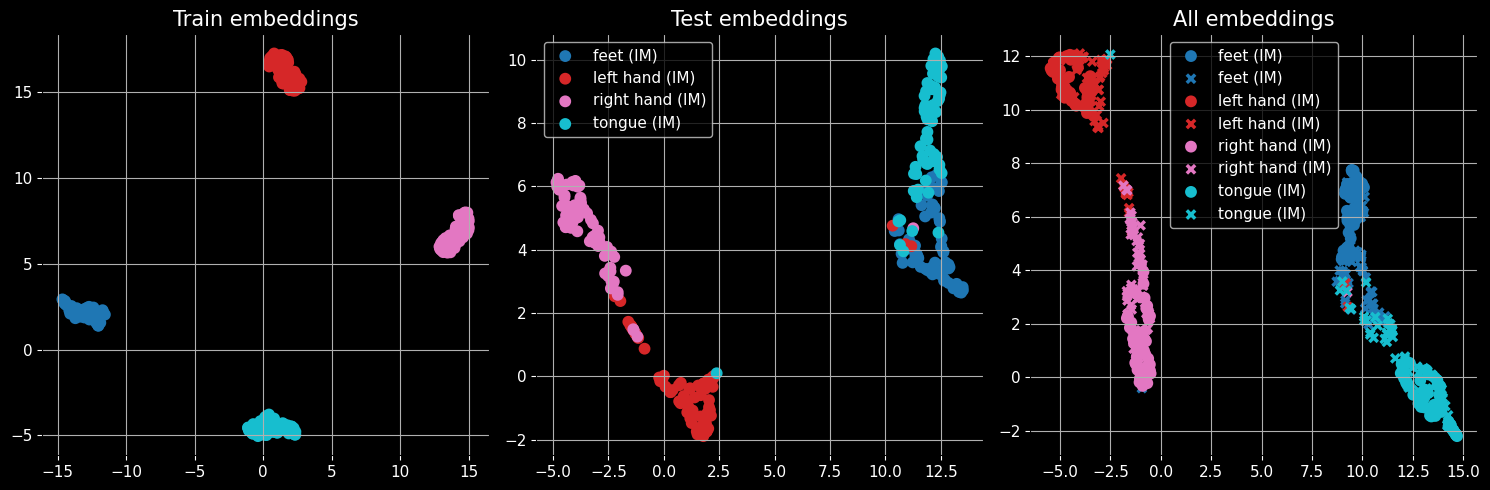

In [16]:
from utils import *

test_labels     = convert_to_str(tf.as_string(tf.reshape(test_samples['labels'], [-1])))
test_embeddings = tf.reshape(test_samples['embeddings'], [-1, test_samples['embeddings'].shape[-1]])

plot_multiple(** {
    'Train embeddings' : {'x' : train_samples['embeddings'], 'ids' : train_samples['labels']},
    'Test embeddings'  : {'x' : test_embeddings, 'ids' : test_labels},
    'All embeddings'   : {
        'x'      : tf.concat([train_samples['embeddings'], test_embeddings], axis = 0),
        'ids'    : convert_to_str(tf.as_string(train_samples['labels'])) + test_labels,
        'marker' : ['o'] * len(train_samples['labels']) + ['x'] * len(test_labels)
    }
}, plot_type = 'embedding', ncols = 3, use_subplots = True)

Matrix shape : (230, 288)


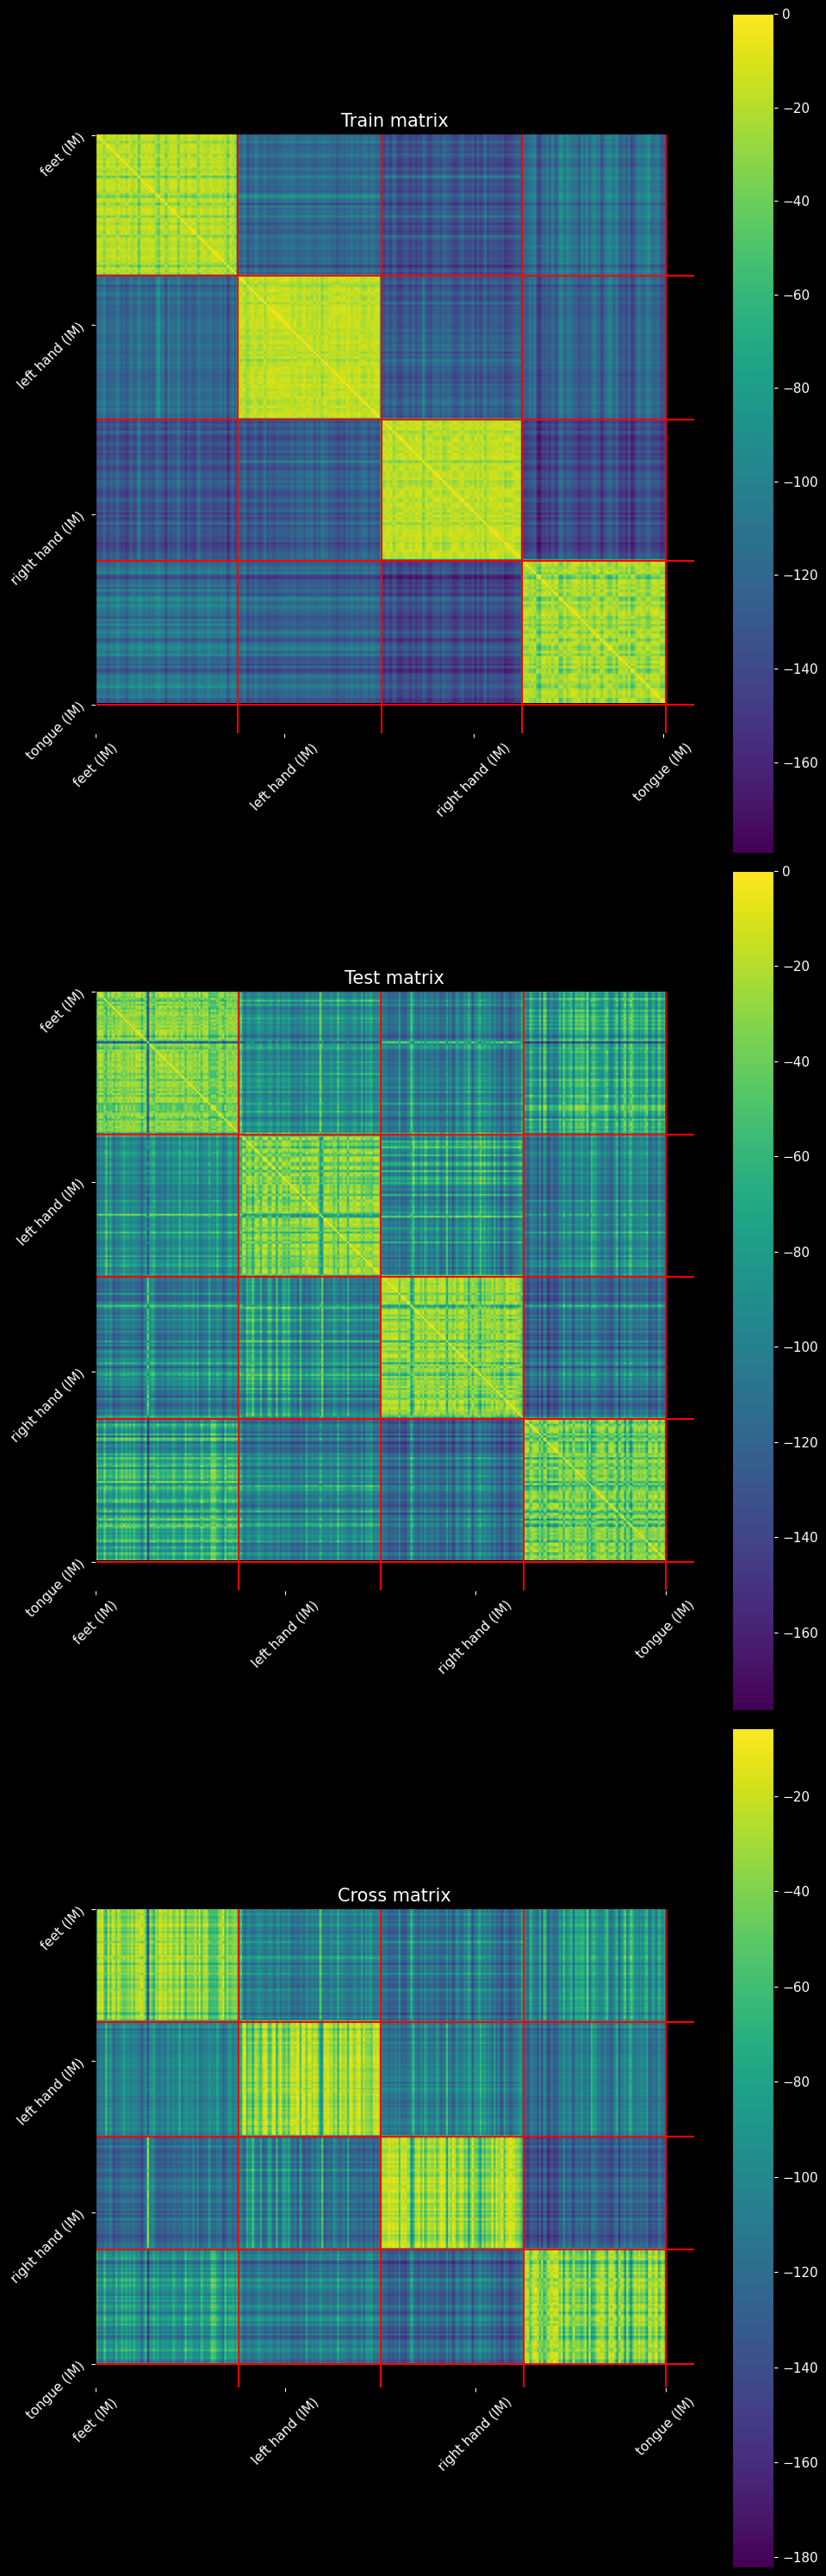

In [17]:
def reorder_samples(samples):
    embeddings, labels = samples['embeddings'], samples['labels']
    if hasattr(labels, 'numpy'): labels = labels.numpy()
    if hasattr(embeddings, 'numpy'): embeddings = embeddings.numpy()
    if len(embeddings.shape) == 3:
        embeddings, labels = np.reshape(embeddings, [-1, embeddings.shape[-1]]), np.reshape(labels, [-1])
    
    order = np.argsort(labels)
    
    labels = labels[order]
    embed  = embeddings[order]
    
    unique_ids, int_ids = tf.unique(labels)
    return embed, convert_to_str(unique_ids), int_ids, np.cumsum(np.bincount(int_ids))

train_embed, train_ids, train_idx, train_lines = reorder_samples(train_samples)
test_embed, test_ids, test_idx, test_lines = reorder_samples(test_samples)

kwargs = {'method' : getattr(model, 'distance_metric', 'euclidian'), 'force_distance' : True, 'as_matrix' : True, 'max_matrix_size' : -1}
matrix = distance(train_embed, test_embed, ** kwargs)

matrices = {
    'Train matrix' : {
        'x' : - distance(train_embed, train_embed, ** kwargs),
        'xtick_labels' : train_ids, 'ytick_labels' : train_ids, 'hlines' : train_lines, 'vlines' : train_lines
    },
    'Test matrix' : {
        'x' : - distance(test_embed, test_embed, ** kwargs),
        'xtick_labels' : test_ids, 'ytick_labels' : train_ids, 'hlines' : test_lines, 'vlines' : test_lines
    },
    'Cross matrix' : {
        'x' : - matrix,
        'xtick_labels' : test_ids, 'ytick_labels' : test_ids, 'hlines' : train_lines, 'vlines' : test_lines
    }
}

print('Matrix shape : {}'.format(matrix.shape))
plot_multiple(** matrices, ncols = 1, plot_type = 'matrix', use_subplots = True, x_size = 10, y_size = 10)

Accuracy for k = -1	: 90.62 %
Accuracy for k = 5	: 90.97 %
Accuracy for k = 10	: 90.97 %
Accuracy for k = 15	: 91.67 %
Accuracy for k = 20	: 90.97 %
Accuracy for k = 25	: 91.32 %
Accuracy for k = 30	: 91.67 %
Accuracy for k = 35	: 91.32 %
Accuracy for k = 40	: 90.97 %
Accuracy for k = 45	: 91.32 %
Accuracy for k = 50	: 91.32 %
Accuracy for k = 55	: 90.97 %
Accuracy for k = 60	: 91.32 %
Accuracy for k = 65	: 90.62 %
Accuracy for k = 70	: 90.97 %
Accuracy for k = 100	: 90.97 %
Accuracy for k = 200	: 91.32 %


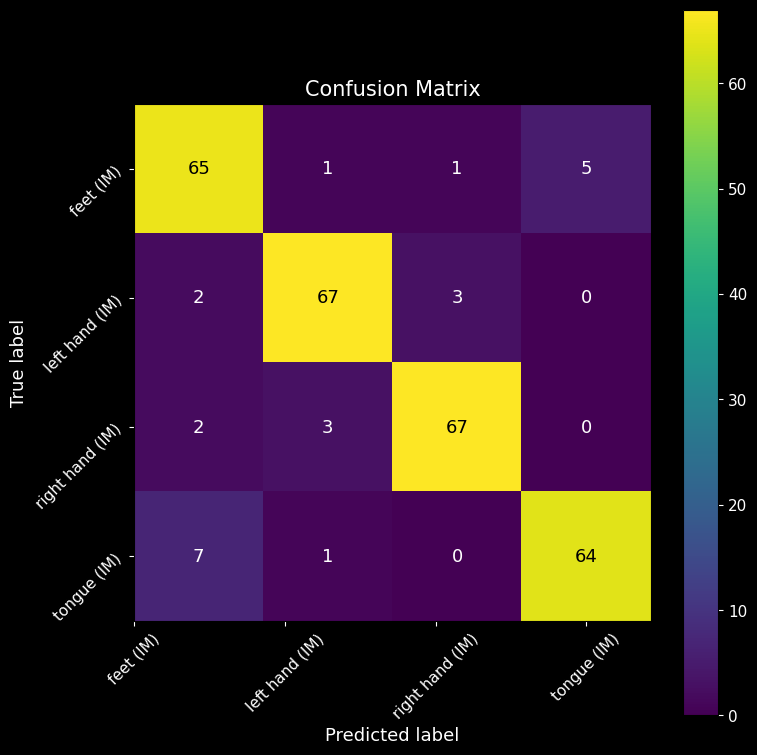

In [18]:
metric = getattr(model, 'distance_metric', 'euclidian')
#metric = 'dp'

for k in [-1] + list(range(5, 75, 5)) + [100, 200]:
    ids, embeddings = compute_centroids(train_embed, train_idx) if k == -1 else (train_idx, train_embed)
    pred = knn(
        test_embed, embeddings, distance_metric = metric, k = max(1, k), ids = ids, weighted = True
    )
    acc = pred == test_idx
    print('Accuracy for k = {}\t: {:.2f} %'.format(k, 100 * np.mean(acc)))
plot_confusion_matrix(true = test_idx, pred = pred, labels = convert_to_str(test_ids), factor_size = 2)

New accuracy : 91.32 %
#0 : 0 != 3 : [0.866 0.541 0.227 1.201]
#5 : 0 != 1 : [0.873 0.957 0.29  0.61 ]
#26 : 0 != 2 : [0.342 0.411 2.47  0.225]
#45 : 0 != 3 : [0.863 0.621 0.267 1.021]
#58 : 0 != 3 : [0.983 0.552 0.23  1.042]
#59 : 0 != 3 : [0.938 0.607 0.241 1.04 ]
#65 : 0 != 3 : [0.924 0.508 0.227 1.035]
#73 : 1 != 0 : [1.176 0.714 0.337 0.603]
#79 : 1 != 2 : [0.455 0.775 1.086 0.315]
#91 : 1 != 2 : [0.523 0.821 0.932 0.336]
#113 : 1 != 0 : [1.333 0.671 0.284 0.615]
#114 : 1 != 2 : [0.501 0.649 1.211 0.364]
#159 : 2 != 0 : [0.923 0.469 0.521 0.704]
#160 : 2 != 1 : [0.533 0.988 0.779 0.349]
#177 : 2 != 1 : [0.545 1.079 0.697 0.377]
#188 : 2 != 0 : [0.797 0.738 0.72  0.342]
#194 : 2 != 1 : [0.595 0.944 0.723 0.39 ]
#236 : 3 != 0 : [1.016 0.615 0.387 0.705]
#248 : 3 != 0 : [1.502 0.585 0.238 0.715]
#250 : 3 != 1 : [0.658 0.907 0.248 0.83 ]
#258 : 3 != 0 : [0.95  0.478 0.216 0.911]
#263 : 3 != 0 : [0.842 0.824 0.261 0.812]
#267 : 3 != 0 : [1.282 0.664 0.319 0.604]
#270 : 3 != 0 : [1.129 

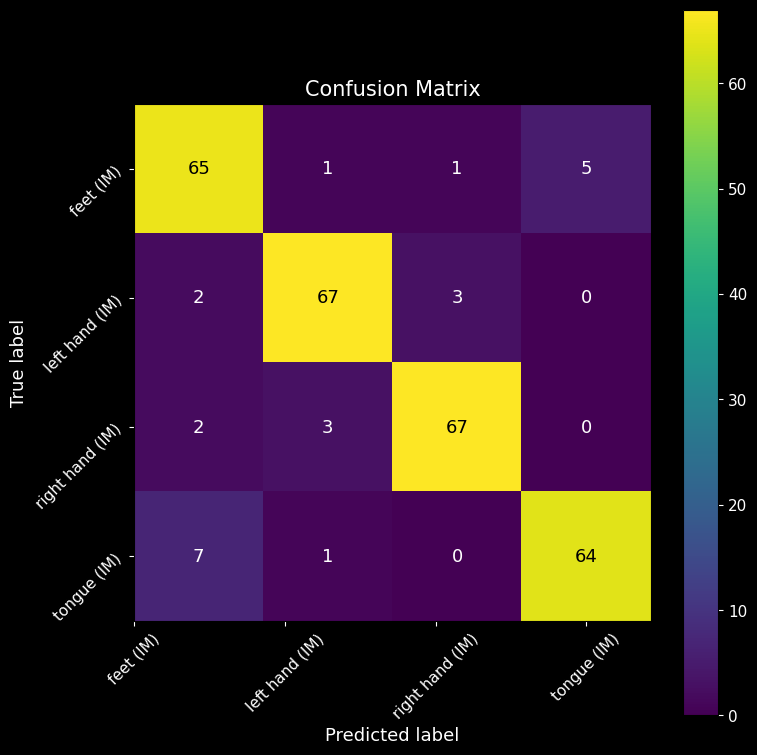

In [20]:
metric = 'euclidian'
metric = model.distance_metric

_, scores = knn(
    test_embed, train_embed, distance_metric = metric, k = 200, ids = train_idx,
    weighted = True, return_scores = True
)
#print(np.around(scores, decimals = 3)[:, :4])

probs = scores / np.sum(scores, axis = -1, keepdims = True)

"""for threshold in [0.5, 0.6, 0.7, 0.8, 0.9]:
    mask = np.max(probs, axis = -1) >= threshold
    print('Accuracy for threshold {} ({:.2f} %) : {:.2f} %'.format(
        threshold, np.mean(mask) * 100, np.mean(pred[mask] == test_idx[mask]) * 100
    ))

scores = scores.numpy()
for i, prob in enumerate(probs):
    if np.max(prob) < 0.6:
        scores[i, np.argmax(prob)] = -np.inf
"""
pred = np.argmax(scores, axis = -1)
print('New accuracy : {:.2f} %'.format(np.mean(pred == test_idx) * 100))

errors = pred != test_idx
for i, (s, t, p) in enumerate(zip(scores, test_idx, pred)):
    if t == p: continue
    print('#{} : {} != {} : {}'.format(i, t, p, np.around(s, decimals = 3)))

plot_confusion_matrix(true = test_idx, pred = pred, labels = convert_to_str(test_ids), factor_size = 2)

### Plots for MLSP 2024 embedding visualization

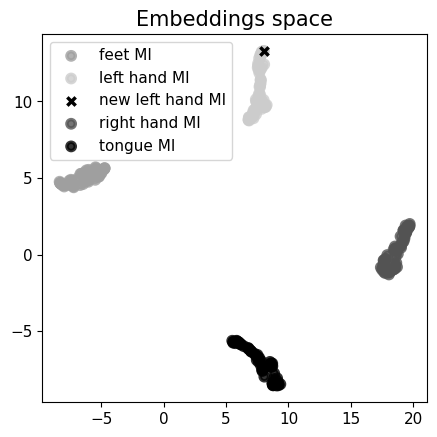

In [13]:
from utils import *

test_labels     = convert_to_str(tf.as_string(tf.reshape(test_samples['labels'], [-1])))
test_embeddings = tf.reshape(test_samples['embeddings'], [-1, test_samples['embeddings'].shape[-1]])

color_config = {
    'fontcolor' : 'black', 'facecolor' : 'white', 'with_grid' : False,
    'title' : 'Embeddings space', 'with_legend' : True
}
_colors = {
    'feet MI' : 1,
    'left hand MI' : 0,
    'right hand MI' : 2,
    'tongue MI' : 3
}

def _normalize_colors(colors, cmap = None):
    if (isinstance(colors, np.ndarray) and colors.dtype in (np.uint8, np.int32, np.int64)) or all(
        isinstance(c, int) for c in colors):
        colors = np.array(list(colors))
        mapper = plt.cm.ScalarMappable(cmap = cmap)
        colors = np.reshape(mapper.to_rgba(np.reshape(colors, [-1])), (len(colors), 4))
    
    return colors

train_labels = [label.replace('(IM)', 'MI') for label in convert_to_str(train_samples['labels'])]
colors = np.array([_colors[l] for l in train_labels])
colors = _normalize_colors(colors, cmap = 'Grays') * 0.8

idx = 3
plot_embedding(
    np.concatenate([train_samples['embeddings'], test_embeddings[idx : idx + 1]], axis = 0),
    train_labels + ['new {}'.format(test_labels[idx]).replace('(IM)', 'MI')],
    marker = ['o'] * len(train_samples['embeddings']) + ['x'],
    c = list(colors) + [[0., 0., 0., 1.]], filename = 'embedding_classification.png',
    ** color_config
)

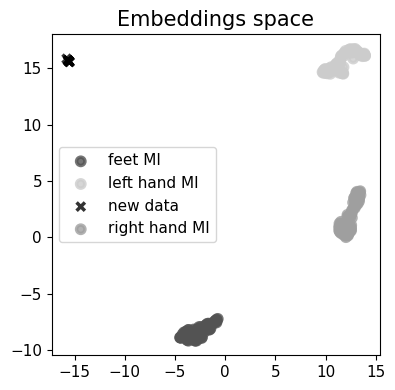

In [11]:
from utils import *

test_labels     = convert_to_str(tf.as_string(tf.reshape(test_samples['labels'], [-1])))
test_embeddings = tf.reshape(test_samples['embeddings'], [-1, test_samples['embeddings'].shape[-1]])

color_config = {
    'fontcolor' : 'black', 'facecolor' : 'white', 'with_grid' : False,
    'title' : 'Embeddings space', 'with_legend' : True
}
_colors = {
    'tongue MI' : 0,
    'left hand MI' : 1,
    'right hand MI' : 2,
    'feet MI' : 3,
    'new data' : 4
}

def _normalize_colors(colors, cmap = None):
    if (isinstance(colors, np.ndarray) and colors.dtype in (np.uint8, np.int32, np.int64)) or all(
        isinstance(c, int) for c in colors):
        colors = np.array(list(colors))
        mapper = plt.cm.ScalarMappable(cmap = cmap)
        colors = np.reshape(mapper.to_rgba(np.reshape(colors, [-1])), (len(colors), 4))
    
    return colors

count = 0
train_labels, embeddings = [], []
for label, emb in zip(convert_to_str(train_samples['labels']), train_samples['embeddings']):
    if label == 'tongue (IM)':
        if count >=10: continue
        label = 'new data'
        count += 1
    embeddings.append(emb)
    train_labels.append(label.replace('(IM)', 'MI'))

colors = np.array([_colors[l] for l in train_labels]) + 1
colors = _normalize_colors(colors, cmap = 'Grays') * 0.8

idx = 3
plot_embedding(
    np.array(embeddings),
    train_labels,
    marker = ['o' if label != 'new data' else 'x' for label in train_labels],
    c = list(colors), filename = 'embedding_label_free.png',
    ** color_config
)

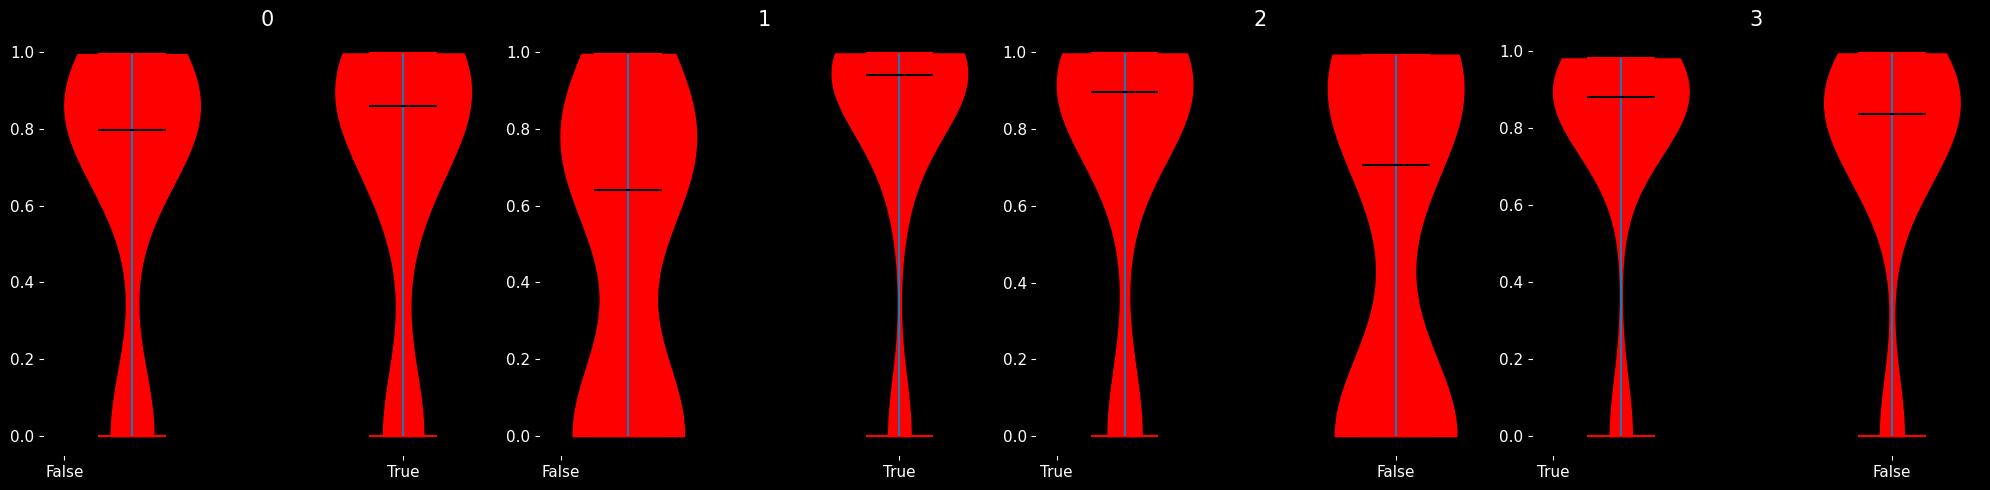

In [52]:
scores_per_label = {}
for s, t, p in zip(scores, np.array(test_idx), np.array(pred)):
    scores_per_label.setdefault(str(t), {}).setdefault(str(t == p), []).append(s[p] / np.sum(s))

#scores_per_label = {
#    k : {ki : np.mean(vi) for ki, vi in v.items()} for k, v in scores_per_label.items()
#}
plot_multiple(
    ** {k : {'x' : v} for k, v in scores_per_label.items()},
    plot_type = 'violinplot', use_subplots = True, ncols = 4
)

Accuracy : 72.57 %
Accuracy : 72.57 %


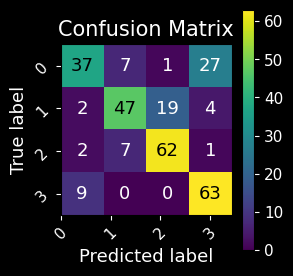

In [43]:
k = 25

_, scores = knn(
    test_embed, train_embed, distance_metric = model.distance_metric, k = k, ids = train_idx, weighted = True, return_scores = True
)

pred = np.argmax(scores, axis = -1)

pred2 = knn(
    test_embed, test_embed, distance_metric = model.distance_metric, k = k, ids = pred, weighted = True
)

order = np.argsort(np.max(scores, axis = -1))[::-1]
indexes = order[:5]

true = test_idx.numpy()

print('Accuracy : {:.2f} %'.format(np.mean(pred == true) * 100))
print('Accuracy : {:.2f} %'.format(np.mean(pred2 == true) * 100))
plot_confusion_matrix(true = true, pred = pred)

#plot(cross_acc, plot_type = 'bar')

In [33]:
labels, scores = model.infer_multi_channels(
    tf.stack(model.get_input(test), axis = 0),
    channels = list(test['channels'].values),
    samples = samples,
    weighted = False,
    k = 15
)
print(scores)

[[[ 0.  7.  0.  8.]
  [ 0. 14.  0.  1.]
  [ 0. 14.  0.  1.]
  ...
  [ 0. 15.  0.  0.]
  [ 0. 15.  0.  0.]
  [ 0. 15.  0.  0.]]

 [[15.  0.  0.  0.]
  [ 0.  0.  0. 15.]
  [ 0.  0.  0. 15.]
  ...
  [ 0.  0.  0. 15.]
  [ 0.  0.  0. 15.]
  [ 0. 14.  0.  1.]]

 [[ 0. 14.  0.  1.]
  [ 0. 15.  0.  0.]
  [ 0. 15.  0.  0.]
  ...
  [ 0. 15.  0.  0.]
  [ 0. 15.  0.  0.]
  [ 0. 15.  0.  0.]]

 ...

 [[ 0.  1.  0. 14.]
  [ 0.  1. 13.  1.]
  [ 0.  2.  2. 11.]
  ...
  [ 0.  0.  2. 13.]
  [ 0.  0.  2. 13.]
  [ 0.  0.  0. 15.]]

 [[ 0.  0.  0. 15.]
  [ 0.  0.  0. 15.]
  [ 0.  0.  0. 15.]
  ...
  [ 0.  0.  0. 15.]
  [ 0.  0.  0. 15.]
  [ 0.  0.  8.  7.]]

 [[14.  1.  0.  0.]
  [15.  0.  0.  0.]
  [15.  0.  0.  0.]
  ...
  [ 1.  8.  5.  1.]
  [ 0.  9.  6.  0.]
  [ 0.  1. 14.  0.]]]


In [23]:
test_idx = test['label'].apply(labels.index).values
print(test_idx)

[3 0 0 3 0 3 0 1 0 2 3 1 0 3 2 2 2 2 2 3 1 0 3 3 1 2 3 1 1 1 3 0 3 0 0 3 0
 1 0 1 1 2 1 1 2 2 2 2 2 1 0 3 3 0 1 2 0 1 3 3 3 2 0 0 3 3 1 3 0 2 2 1 3 2
 2 0 2 2 0 3 0 1 1 1 2 1 3 2 0 1 0 1 2 0 1 3 3 3 2 0 3 1 3 1 0 2 3 1 1 3 1
 0 2 2 2 1 3 2 0 2 0 3 1 0 3 1 1 3 1 2 2 0 3 0 2 0 2 1 0 0 0 1 2 3 0 2 3 1
 1 2 3 3 1 0 2 2 2 0 3 1 0 2 3 2 1 0 2 2 3 0 0 1 2 0 3 3 2 0 3 1 0 0 1 3 2
 1 1 1 1 3 0 3 0 3 3 1 1 0 1 2 3 2 3 3 0 2 1 0 2 1 2 1 2 0 0 2 3 0 0 0 1 2
 3 2 3 1 3 2 3 1 3 0 1 1 2 3 0 2 0 1 1 3 2 0 2 3 3 1 1 0 2 0 0 3 0 2 2 0 0
 0 0 2 2 1 2 3 0 1 0 3 2 3 2 3 3 3 3 1 1 2 0 1 1 1 2 1 3 1]


Accuracy (k = 50) : 35.76 %


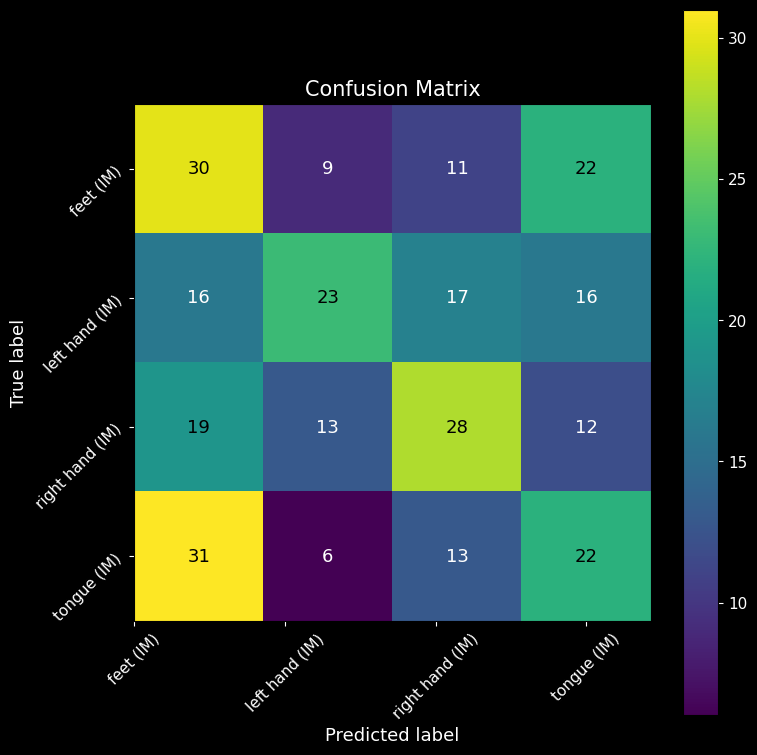

In [38]:
channels = [0, 12]
pred = np.argmax(np.sum(scores[:, channels], axis = 1), axis = -1)

print('Accuracy (k = {}) : {:.2f} %'.format(k, np.mean(pred == test_idx) * 100))
plot_confusion_matrix(true = test_idx, pred = pred, labels = convert_to_str(test_ids), factor_size = 2)

## Test evaluation

In [2]:
from datasets import print_datasets, get_dataset

print_datasets()

ds = get_dataset('mnistep')
ds

Task BCI :	('bciiv2a', 'brainmnist', 'mnistin', 'mnistmu', 'mnistmw', 'mnistep', 'eegmmidb', 'largescalebci')
Task Sleep analysis :	('cinc',)
Task EEG emotion recognition :	('seed',)
Available keras datasets : ['cifar10', 'cifar100', 'fashion_mnist', 'imdb', 'mnist', 'reuters']
Loading dataset mnistep...


,event_id,event_name,device,rate,channels,eeg,start,end,time,label,id,n_channels,dataset_name
0,67635,6,EP,128,"[AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6...","[[0.004395385, 0.004382564, 0.004377436, 0.004...",0,260,260,6,Brain MNIST,14,Brain MNIST
1,67636,7,EP,128,"[AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6...","[[0.004385641, 0.0043815384, 0.0043866667, 0.0...",260,520,260,7,Brain MNIST,14,Brain MNIST
2,67637,9,EP,128,"[AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6...","[[0.004380513, 0.004389744, 0.0043958975, 0.00...",520,776,256,9,Brain MNIST,14,Brain MNIST
3,67638,9,EP,128,"[AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6...","[[0.0043958975, 0.004390769, 0.0044035898, 0.0...",776,1040,264,9,Brain MNIST,14,Brain MNIST
4,67639,0,EP,128,"[AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6...","[[0.004395385, 0.004385128, 0.004382051, 0.004...",1040,1300,260,0,Brain MNIST,14,Brain MNIST
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65029,132664,-1,EP,128,"[AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6...","[[0.004401026, 0.004413846, 0.0044107693, 0.00...",16875817,16876073,256,-1,Brain MNIST,14,Brain MNIST
65030,132665,-1,EP,128,"[AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6...","[[0.004419487, 0.0044184616, 0.0044230768, 0.0...",16876073,16876329,256,-1,Brain MNIST,14,Brain MNIST
65031,132666,-1,EP,128,"[AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6...","[[0.004414872, 0.004402564, 0.0043923077, 0.00...",16876329,16876585,256,-1,Brain MNIST,14,Brain MNIST
65032,132667,-1,EP,128,"[AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6...","[[0.0044897436, 0.004491282, 0.004489231, 0.00...",16876585,16876841,256,-1,Brain MNIST,14,Brain MNIST


In [2]:
import os
import importlib
import numpy as np
import pandas as pd

from tqdm import tqdm

from experiments import scenarios, data_utils, get_experimental_data, build_model, validate_scenario_data
from experiments.scenarios import _setup_gpu_config, _get_scenario_config, _get_metrics

importlib.reload(data_utils)

model_name = 'atcnet_orig_subj-1-2-3-4-5-6-7-8-9_run-0_lss_scenario-2'

config = _get_scenario_config(model_name, gpu = 0)

_setup_gpu_config(config, gpu = 0)

train, valid, test, config = data_utils.get_experimental_data(
    config, random_state = config['run']
)

validate_scenario_data(config, train = train, valid = valid, test = test)

model, config = build_model(model_name, config)

2024-02-15 09:31:52.362809: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-15 09:31:52.393612: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 09:31:52.393640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 09:31:52.394374: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 09:31:52.399188: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
experimental_follow_type_hints is deprecated
Loading dataset bci-iv_2a...


2024-02-15 09:32:15.946880: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14948 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:17:00.0, compute capability: 7.5


`val_split is None`, which makes the validation and test sets equal ! Make sure that it is expected

Dataset information

General :
  - sampling rate  : 250
  - # EEG channels : 22
  - Labels (n = 36) : ['BCI-IV 2a-7-left hand (IM)', 'BCI-IV 2a-4-right hand (IM)', 'BCI-IV 2a-2-feet (IM)', 'BCI-IV 2a-4-left hand (IM)', 'BCI-IV 2a-7-tongue (IM)', ...]

# Samples :
  - Train size    : 4147
  - Valid size    : 1037
  - Test size     : 1037
  - valid == test : True

Subjects :
  - # subject(s) in train : 9
  - # subject(s) in valid : 9
  - # subject(s) in test  : 9
  - # subject(s) in train and valid : 9
  - # subject(s) in train and test  : 9

Sessions :
  - # session(s) in train : 18
  - # session(s) in valid : 18
  - # session(s) in test  : 18
  - # session(s) in train and valid : 18
  - # session(s) in train and test  : 18

Model restoration...
Model model has not been restored due to an exception : Requested the deserialization of a Lambda layer with a Python `lambda` inside it. This c

In [3]:
importlib.reload(scenarios)

config['metrics'] = scenarios._get_metrics(model_name, config)

config

{'scenario': 2,
 'model_name': 'atcnet_orig_subj-1-2-3-4-5-6-7-8-9_run-0_lss_scenario-2',
 'model_type': 'classifier',
 'pretrained': None,
 'skip_new': False,
 'scenario_config': {'train_on_multi_subjects': True},
 'dataset_config': {'task': 'classification',
  'test_task': 'classification',
  'dataset': 'bci-iv_2a',
  'subjects': ['1', '2', '3', '4', '5', '6', '7', '8', '9'],
  'loso': 0,
  'val_split': None,
  'test_split': 0.2,
  'per_user_label': True,
  'time_window': 4.5,
  'offset': 1.5,
  'test_sessions': 0},
 'model_config': {'nom': 'atcnet_orig_subj-1-2-3-4-5-6-7-8-9_run-0_lss_scenario-2',
  'rate': 250,
  'architecture_name': 'atcnet',
  'normalization_config': {'normalize': <EEGNormalization.GLOBAL_NORMAL: 5>,
   'per_channel': True},
  'keep_spatial_information': 'auto',
  'max_input_length': 4.5,
  'use_fixed_length_input': True,
  'channels': ['EEG-1',
   'EEG-2',
   'EEG-3',
   'EEG-4',
   'EEG-5',
   'EEG-6',
   'EEG-7',
   'EEG-8',
   'EEG-9',
   'EEG-10',
   'EEG-11

In [5]:
filepath = model.save_dir + '/best_weights.keras'
model.load_weights(filepath)
pred = model.predict(test, mask_by_id = True)

print(np.mean([v for k, v in config['metrics'].items() if 'masked' in k and v is not None]))
print(np.mean(np.array([p['pred'] for p in pred]) == test['label'].values))

0.8273294568061829
0.8273866923818708


In [9]:
import os
import json
import logging
import numpy as np
import pandas as pd

from utils import to_json

logger = logging.getLogger(__name__)

importlib.reload(scenarios)

metrics = scenarios.evaluate_model(
    model, config, data = test, filepath = filepath, save = False
)
metrics

Model `atcnet_orig_subj-1-2-3-4-5-6-7-8-9_run-0_lss_scenario-2` metrics : {
    "test_accuracy": 0.8273866923818708,
    "test_subj-BCI-IV 2a-1_accuracy": 0.8620689655172413,
    "test_subj-BCI-IV 2a-2_accuracy": 0.6810344827586207,
    "test_subj-BCI-IV 2a-3_accuracy": 0.9217391304347826,
    "test_subj-BCI-IV 2a-4_accuracy": 0.7739130434782608,
    "test_subj-BCI-IV 2a-5_accuracy": 0.8608695652173913,
    "test_subj-BCI-IV 2a-6_accuracy": 0.7368421052631579,
    "test_subj-BCI-IV 2a-7_accuracy": 0.896551724137931,
    "test_subj-BCI-IV 2a-8_accuracy": 0.8508771929824561,
    "test_subj-BCI-IV 2a-9_accuracy": 0.8620689655172413
}
Model `atcnet_orig_subj-1-2-3-4-5-6-7-8-9_run-0_lss_scenario-2` metrics : {
    "test_masked_accuracy": 0.8273866923818708,
    "test_masked_subj-BCI-IV 2a-1_accuracy": 0.8620689655172413,
    "test_masked_subj-BCI-IV 2a-2_accuracy": 0.6810344827586207,
    "test_masked_subj-BCI-IV 2a-3_accuracy": 0.9217391304347826,
    "test_masked_subj-BCI-IV 2a-4_accuracy

{'test_accuracy': 0.8273866923818708,
 'test_subj-BCI-IV 2a-1_accuracy': 0.8620689655172413,
 'test_subj-BCI-IV 2a-2_accuracy': 0.6810344827586207,
 'test_subj-BCI-IV 2a-3_accuracy': 0.9217391304347826,
 'test_subj-BCI-IV 2a-4_accuracy': 0.7739130434782608,
 'test_subj-BCI-IV 2a-5_accuracy': 0.8608695652173913,
 'test_subj-BCI-IV 2a-6_accuracy': 0.7368421052631579,
 'test_subj-BCI-IV 2a-7_accuracy': 0.896551724137931,
 'test_subj-BCI-IV 2a-8_accuracy': 0.8508771929824561,
 'test_subj-BCI-IV 2a-9_accuracy': 0.8620689655172413,
 'test_masked_accuracy': 0.8273866923818708,
 'test_masked_subj-BCI-IV 2a-1_accuracy': 0.8620689655172413,
 'test_masked_subj-BCI-IV 2a-2_accuracy': 0.6810344827586207,
 'test_masked_subj-BCI-IV 2a-3_accuracy': 0.9217391304347826,
 'test_masked_subj-BCI-IV 2a-4_accuracy': 0.7739130434782608,
 'test_masked_subj-BCI-IV 2a-5_accuracy': 0.8608695652173913,
 'test_masked_subj-BCI-IV 2a-6_accuracy': 0.7368421052631579,
 'test_masked_subj-BCI-IV 2a-7_accuracy': 0.8965517

## Test data loading

In [25]:
import json
import importlib

from utils import set_display_options
from experiments import data_utils, model_utils, scenarios

set_display_options()

for module in (model_utils, data_utils, scenarios): importlib.reload(module)

model_name = 'atcnet_task-cli_subj-1_run-10'

config = scenarios._get_scenario_config(model_name)
train, val, test, config = data_utils.get_experimental_data(config)
print(json.dumps(config, indent = 4))

print(train.head())
print(test.head())

Loading dataset bciiv2a...

Dataset information

General :
  - sampling rate  : 250
  - # EEG channels : 1

Labels :
  - Label in train (n = 88) : ['right hand (IM)-EEG-3', 'feet (IM)-EEG-20', 'left hand (IM)-EEG-15', 'feet (IM)-EEG-17', 'left hand (IM)-EEG-17', ...]
  - Label in valid (n = 88) : ['feet (IM)-EEG-20', 'right hand (IM)-EEG-3', 'left hand (IM)-EEG-15', 'feet (IM)-EEG-17', 'left hand (IM)-EEG-17', ...]
  - Label in test  (n = 4) : {'feet (IM)', 'tongue (IM)', 'left hand (IM)', 'right hand (IM)'}
  - # label(s) in train and valid : 88
  - # label(s) in train and test  : 0

# Samples :
  - Train size    : 5060
  - Valid size    : 1276
  - Test size     : 288
  - valid == test : False

Subjects :
  - # subject(s) in train : 1
  - # subject(s) in valid : 1
  - # subject(s) in test  : 1
  - # subject(s) in train and valid : 1
  - # subject(s) in train and test  : 1

Sessions :
  - # session(s) in train : 1
  - # session(s) in valid : 1
  - # session(s) in test  : 1
  - # sessio

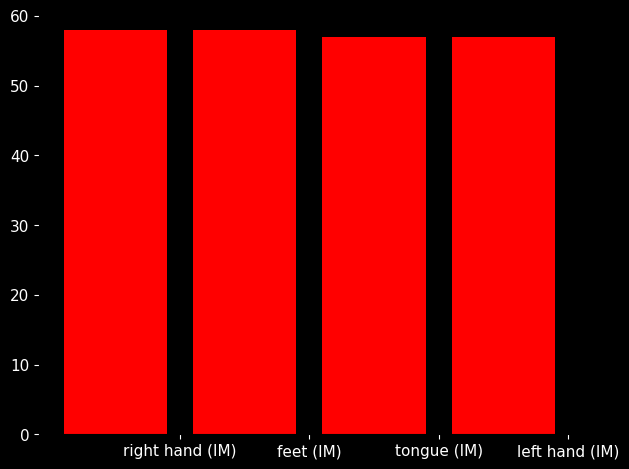

label
right hand (IM)    58
feet (IM)          58
tongue (IM)        57
left hand (IM)     57
Name: count, dtype: int64

In [24]:
from utils import plot

plot(train['label'].value_counts().to_dict(), plot_type = 'bar')
train['label'].value_counts()

## Test GE2E generator

In [5]:
import json
import importlib
import tensorflow as tf

from datasets import get_dataset, prepare_dataset
from custom_train_objects.generators import eeg_generator

try:
    tf.config.set_visible_devices([], 'GPU')
except:
    pass

In [9]:
data = get_dataset('bci-iv_2a', modes = 'train', subjects = 1)

print('Dataset columns : {}'.format(list(data.columns)))
print('# data : {}'.format(len(data)))

Loading dataset bciiv2a...
Dataset columns : ['event_id', 'start', 'end', 'time', 'age', 'sex', 'meas_date', 'event_name', 'artifact', 'rate', 'channels', 'eeg', 'id', 'session', 'label', 'n_channels', 'dataset_name']
# data : 288


In [10]:
importlib.reload(eeg_generator)

generator = eeg_generator.EEGGrouperGenerator(
    data, n_utterance = 4, n_round = 10
)
print(generator)

EEGGrouper Generator :
- Length : 160
- Unique ids   : 4
- Total files  : 160
- Unique files : 120 (75.00 %)
- Cache size   : 0 (loaded : 0.00 %)


In [13]:
dataset = prepare_dataset(generator, batch_size = 16, padded_batch = True)
for batch in dataset.take(5):
    print(batch['label'])


tf.Tensor(
[b'feet (IM)' b'feet (IM)' b'feet (IM)' b'feet (IM)' b'left hand (IM)'
 b'left hand (IM)' b'left hand (IM)' b'left hand (IM)' b'right hand (IM)'
 b'right hand (IM)' b'right hand (IM)' b'right hand (IM)' b'tongue (IM)'
 b'tongue (IM)' b'tongue (IM)' b'tongue (IM)'], shape=(16,), dtype=string)
tf.Tensor(
[b'feet (IM)' b'feet (IM)' b'feet (IM)' b'feet (IM)' b'left hand (IM)'
 b'left hand (IM)' b'left hand (IM)' b'left hand (IM)' b'right hand (IM)'
 b'right hand (IM)' b'right hand (IM)' b'right hand (IM)' b'tongue (IM)'
 b'tongue (IM)' b'tongue (IM)' b'tongue (IM)'], shape=(16,), dtype=string)
tf.Tensor(
[b'feet (IM)' b'feet (IM)' b'feet (IM)' b'feet (IM)' b'left hand (IM)'
 b'left hand (IM)' b'left hand (IM)' b'left hand (IM)' b'right hand (IM)'
 b'right hand (IM)' b'right hand (IM)' b'right hand (IM)' b'tongue (IM)'
 b'tongue (IM)' b'tongue (IM)' b'tongue (IM)'], shape=(16,), dtype=string)
tf.Tensor(
[b'feet (IM)' b'feet (IM)' b'feet (IM)' b'feet (IM)' b'left hand (IM)'
 b'lef

2024-02-19 10:18:27.713657: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Test experiments

In [12]:
import json
import importlib

from utils import to_json

from experiments import model_utils, scenarios_utils

importlib.reload(model_utils)
importlib.reload(scenarios_utils)

test = False

_suffixes      = ['', '_lss', '_norm-no', '_norm-no_lss', '_norm-no_win', '_norm-no_lss_win']
_orig_suffixes = ['', '_lss'] if not test else ['']

_scenarios = ['_scenario-1', '_scenario-2', '_scenario-3', '_scenario-4'] #if not test else ['_scenario-3']
original_experimental_models = (
    'atcnet_orig_subj-{subject}_run-{run}',
    'atcnet_subj-{subject}_run-{run}',
    'eegnex_subj-{subject}_run-{run}',
    'eegtcnet_subj-{subject}_run-{run}',
    'deepconvnet_subj-{subject}_run-{run}'
)

experimental_models = []
for exp in original_experimental_models[:2]:
    experimental_models.extend([
        exp + suffix for suffix in (_suffixes if 'orig' not in exp else _orig_suffixes)
    ])

experiments = []
for exp in experimental_models:
    experiments.extend([
        exp + scenario for scenario in _scenarios
    ])


for name in experiments:
    config = model_utils.get_model_config(name)
    print('{} : {}'.format(name, json.dumps(to_json(config), indent = 4)))
    config = scenarios_utils.add_scenario_config(config['scenario'], config)
    print('Updated config : {}\n\n'.format(json.dumps(to_json(config), indent = 4)))
    try:
        scenarios_utils.validate_scenario_config(config['scenario'], config)
    except scenarios_utils.InvalidScenarioException as e:
        print('This scenario is invalid : {}\n\n'.format(e))


Unknown json data (<class 'function'>) : <function get_model_config.<locals>.<lambda> at 0x7f4b50cc7920>
atcnet_orig_subj-{subject}_run-{run}_scenario-1 : {
    "scenario": 1,
    "model_type": "classifier",
    "pretrained": null,
    "scenario_config": {},
    "dataset_config": {
        "dataset": "bci-iv_2a",
        "subjects": null,
        "loso": 0,
        "val_split": null,
        "per_user_label": false,
        "time_window": 4.5,
        "offset": 1.5
    },
    "model_config": {
        "architecture_name": "atcnet",
        "normalization_config": {
            "normalize": 5,
            "per_channel": true
        },
        "keep_spatial_information": "auto",
        "max_input_length": 4.5,
        "use_fixed_length_input": true
    },
    "compile_config": {
        "optimizer": "adam",
        "optimizer_config": {
            "lr": 0.001
        }
    },
    "train_config": {
        "epochs": 1000,
        "batch_size": 64,
        "monitor": "test_accuracy",
  

## Test label mapping

In [ ]:
import importlib
import tensorflow as tf

from utils.eeg_utils import label_utils

try:
    tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[:1], 'GPU')
except:
    pass

importlib.reload(label_utils)

labels  = [None, 'bci', 'sleep']
mapping = [None, ('left', 'right'), ('stage_1', 'stage_2')]

print(label_utils.build_lookup_table(labels, mapping))